# K-Means / Audio-Visual Extraction

## Imports + Loading in Data

In [ ]:
!pip install yt-dlp
!yt-dlp -f bestaudio -x --audio-format mp3 --user-agent "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36" https://youtu.be/mauBfuFwLFI


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import librosa
import numpy as np
import pandas as pd
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import librosa.display


In [ ]:
# YAMNet model (pretrained)
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

#video 3 and 18 not accessible due to copy right issues
audio_files = ['Air France [yEKe5xrAsyo].mp3', 'Be Kind [hyQpXYFhL2A].mp3', 'Interstellar [n2ks3g5fySE].mp3', 'Mr. Rogers Testimony [iiFEiUe8k8U].mp3', 'Hunger Games [LY2BbmeAP6M].mp3',
               'Cloud Atlas [tnXHFqw1ckk].mp3', 'A Thing About Life [5MveHH5k10I].mp3', 'Remember the Titans [RbWWQbMqKdQ].mp3',
               'Amélie [7BLhxyMyNOc].mp3', 'Thai Medicine [mn26zmFwUNk].mp3', 'Unsung Hero (Thai Insurance) [cEbh8SThLAA].mp3', 'Muhammed Ali [FjPv3B8jQmw].mp3',
               'Perfect Planet [kV06adZPr8k].mp3', 'Italy Balconies [5LPzYo9Cins].mp3', 'Mr. Rogers Doc [xJvF2sFKRcU].mp3', 'Hans Zimmer Time [6d6cYCyXjwQ].mp3',
               'Rocky [q8hSfUY36_U].mp3', 'Great Dictator [VMgdGswaI5s].mp3', 'We Think Too Much and Feel Too Little [1QmdjvBmeaU].mp3',
               'Aramaic Choir [Zxqjf34ncUY].mp3', 'Dead Poets [Oj-1rJn8-sU].mp3', 'Feynmann [mauBfuFwLFI].mp3']

In [ ]:

df_tempo_chroma = pd.DataFrame(columns=["file", "tempo", "chroma"])

for file in audio_files:
    audio, sr = librosa.load(file, sr=None)
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    features = {
        "file": file,
        "tempo": tempo,
        "chroma": chroma.tolist()  # Convert to list for storage
    }

    features_df = pd.DataFrame([features])
    df_tempo_chroma = pd.concat([df_tempo_chroma, features_df], ignore_index=True)

# Save to disk
df_tempo_chroma.to_pickle("tempo_chroma.pkl")

In [ ]:
df_mfcc = pd.DataFrame(columns=["file", "mfcc"])

for file in audio_files:
    audio, sr = librosa.load(file, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    features = {
        "file": file,
        "mfcc": mfcc.tolist()
    }

    features_df = pd.DataFrame([features])
    df_mfcc = pd.concat([df_mfcc, features_df], ignore_index=True)

# Save to disk
df_mfcc.to_pickle("mfcc.pkl")

In [ ]:
df_spectrogram = pd.DataFrame(columns=["file", "spectrogram"])

for file in audio_files:
    audio, sr = librosa.load(file, sr=None)

    # Compute Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)

    # Truncate to the first 1000 time frames to reduce size
    D = D[:, :1000]  # Adjust 1000 to a suitable value for your dataset

    features = {
        "file": file,
        "spectrogram": D.tolist()  # Convert to list for storage
    }

    features_df = pd.DataFrame([features])
    df_spectrogram = pd.concat([df_spectrogram, features_df], ignore_index=True)

# Save to disk as pickle
df_spectrogram.to_pickle("spectrogram_truncated.pkl")

NameError: name 'audio_files' is not defined

In [ ]:
df_tempo_chroma = pd.read_pickle("tempo_chroma.pkl")
df_mfcc = pd.read_pickle("mfcc.pkl")
df_spectrogram = pd.read_pickle("spectrogram_truncated.pkl")

# Merge on the "file" column
df_combined = df_tempo_chroma.merge(df_mfcc, on="file").merge(df_spectrogram, on="file")

# Save the combined dataset
df_combined.to_pickle("combined_features.pkl")

# Verify the result
print(df_combined.head())


                                     file                 tempo  \
0            Air France [yEKe5xrAsyo].mp3   [80.35714285714286]   
1               Be Kind [hyQpXYFhL2A].mp3   [127.8409090909091]   
2          Interstellar [n2ks3g5fySE].mp3               [187.5]   
3  Mr. Rogers Testimony [iiFEiUe8k8U].mp3            [117.1875]   
4          Hunger Games [LY2BbmeAP6M].mp3  [100.44642857142857]   

                                              chroma  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.32852381467819214, 0.92249834537...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.4831124246120453, 0.77...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                mfcc  \
0  [[-647.0265502929688, -647.0265502929688, -647...   
1  [[-660.60107421875, -660.60107421875, -660.601...   
2  [[-511.89825439453125, -511.89825439453125, -5...   
3  [[-738.5291137695312, -738.529113

In [ ]:
# Use custom mapping to simplify df names

df_combined['file'] = df_combined['file'].replace({'Air France [yEKe5xrAsyo].mp3': 'Air France', 'Be Kind [hyQpXYFhL2A].mp3': 'Be Kind (Everything Everywhere All At Once)',
       'Interstellar [n2ks3g5fySE].mp3': 'Interstellar with Hans Zimmer',
       'Mr. Rogers Testimony [iiFEiUe8k8U].mp3': 'Mr Rogers Testimony',
       'Hunger Games [LY2BbmeAP6M].mp3': 'Hunger Games', 'Cloud Atlas [tnXHFqw1ckk].mp3': 'Cloud Atlas',
       'A Thing About Life [5MveHH5k10I].mp3': 'A Thing About Life',
       'Remember the Titans [RbWWQbMqKdQ].mp3': 'Remembering the Titans',
       'Amélie [7BLhxyMyNOc].mp3': 'Amélie - Helping a Blind Man', 'Thai Medicine [mn26zmFwUNk].mp3': 'Giving Is The Best Communication',
       'Unsung Hero (Thai Insurance) [cEbh8SThLAA].mp3': 'Unsung Hero',
       'Muhammed Ali [FjPv3B8jQmw].mp3': 'Muhammed Ali',
       'Perfect Planet [kV06adZPr8k].mp3': 'A Perfect Planet',
       'Italy Balconies [5LPzYo9Cins].mp3': 'Italians Making Music on Balconies Under Coronavirus Quarantine',
       'Mr. Rogers Doc [xJvF2sFKRcU].mp3': "Won't You Be My Neighbor? (Mr. Roger's Documentary)",
       'Hans Zimmer Time [6d6cYCyXjwQ].mp3': 'Hans Zimmer - Time', 'Rocky [q8hSfUY36_U].mp3': 'Rocky - Retrospective',
       'Great Dictator [VMgdGswaI5s].mp3': 'The Great Dictator',
       'We Think Too Much and Feel Too Little [1QmdjvBmeaU].mp3': 'We Think Too Much and Feel Too Little',
       'Aramaic Choir [Zxqjf34ncUY].mp3': 'Aramaic Choir', 'Dead Poets [Oj-1rJn8-sU].mp3': "Dead Poet's Society - YAWP Scene",
       'Feynmann [mauBfuFwLFI].mp3': 'The Feynmann Series - Beauty'})

In [ ]:
df_combined

,file,tempo,chroma,mfcc,spectrogram
0,Air France,[80.35714285714286],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-647.0265502929688, -647.0265502929688, -647...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1,Be Kind (Everything Everywhere All At Once),[127.8409090909091],"[[0.0, 0.0, 0.32852381467819214, 0.92249834537...","[[-660.60107421875, -660.60107421875, -660.601...","[[-80.0, -80.0, -80.0, -56.63422393798828, -47..."
2,Interstellar with Hans Zimmer,[187.5],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-511.89825439453125, -511.89825439453125, -5...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
3,Mr Rogers Testimony,[117.1875],"[[0.0, 0.0, 0.0, 0.0, 0.4831124246120453, 0.77...","[[-738.5291137695312, -738.5291137695312, -738...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -4..."
4,Hunger Games,[100.44642857142857],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-518.4585571289062, -518.4585571289062, -518...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
5,Cloud Atlas,[140.625],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.175630077719...","[[-701.0570678710938, -701.0570678710938, -701...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
6,A Thing About Life,[127.8409090909091],"[[0.0, 0.0, 0.0, 0.0, 0.7656816244125366, 0.17...","[[-572.2612915039062, -572.2612915039062, -572...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
7,Remembering the Titans,[170.45454545454547],"[[0.9426167607307434, 0.8684483766555786, 0.63...","[[-620.0328369140625, -514.9336547851562, -418...","[[-80.0, -55.7246208190918, -40.66511917114258..."
8,Amélie - Helping a Blind Man,[137.1951219512195],"[[0.0, 0.0, 0.3292030990123749, 0.635851442813...","[[-590.316162109375, -590.316162109375, -590.3...","[[-80.0, -80.0, -80.0, -73.77366638183594, -64..."
9,Giving Is The Best Communication,[53.57142857142857],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-663.9107055664062, -663.9107055664062, -663...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."


In [ ]:
def truncate_2d(arr, target_shape=(12, 1000)):
    """Truncate a 2D array to match the target_shape (frequency bins, time frames)."""
    arr = np.array(arr)
    target_freq, target_time = target_shape
    return arr[:target_freq, :target_time]


# Apply to each feature column
df_combined['mfcc'] = df_combined['mfcc'].apply(lambda x: truncate_2d(x, target_shape=(13, 1000)))
df_combined['chroma'] = df_combined['chroma'].apply(lambda x: truncate_2d(x, target_shape=(12, 1000)))
df_combined['spectrogram'] = df_combined['spectrogram'].apply(lambda x: truncate_2d(x, target_shape=(1025, 1000)))
# Convert single-element lists to scalars
df_combined['tempo'] = df_combined['tempo'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0)


In [ ]:
# Function to apply Incremental PCA on a specific feature column
def apply_incremental_pca(features_list, n_components, prefix, batch_size=100):
    X = np.array([np.array(feature).flatten() for feature in features_list])  # Flatten each feature
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    X_pca = ipca.fit_transform(X_scaled)

    pca_columns = [f"{prefix}_pca_{i+1}" for i in range(n_components)]
    return pd.DataFrame(X_pca, columns=pca_columns)

# Apply Incremental PCA to each feature group
df_mfcc_pca = apply_incremental_pca(df_combined["mfcc"], n_components=10, prefix="mfcc", batch_size=50)
df_chroma_pca = apply_incremental_pca(df_combined["chroma"], n_components=5, prefix="chroma", batch_size=50)
df_spectrogram_pca = apply_incremental_pca(df_combined["spectrogram"], n_components=20, prefix="spectrogram", batch_size=50)

# Merge reduced features into the main DataFrame
df_combined = pd.concat([df_combined.reset_index(drop=True), df_mfcc_pca, df_chroma_pca, df_spectrogram_pca], axis=1)

# Save the resulting DataFrame to disk
df_combined.to_pickle("reduced_features.pkl")
print(df_combined.head())


                                          file  tempo  \
0                                   Air France      0   
1  Be Kind (Everything Everywhere All At Once)      0   
2                Interstellar with Hans Zimmer      0   
3                          Mr Rogers Testimony      0   
4                                 Hunger Games      0   

                                              chroma  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.32852381467819214, 0.92249834537...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.4831124246120453, 0.77...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                mfcc  \
0  [[-647.0265502929688, -647.0265502929688, -647...   
1  [[-660.60107421875, -660.60107421875, -660.601...   
2  [[-511.89825439453125, -511.89825439453125, -5...   
3  [[-738.5291137695312, -738.5291137695312, -738...   
4  [[-518.4585571289062, -518.4585571289

In [ ]:
df_combined = df_combined.drop(columns = ['spectrogram', 'mfcc', 'chroma'])

# Combine spectrogram PCA columns into a single list column
df_combined["spectrogram_pca"] = df_combined[[f"spectrogram_pca_{i+1}" for i in range(20)]].values.tolist()

# Combine mfcc PCA columns into a single list column
df_combined["mfcc_pca"] = df_combined[[f"mfcc_pca_{i+1}" for i in range(10)]].values.tolist()

# Combine chroma PCA columns into a single list column
df_combined["chroma_pca"] = df_combined[[f"chroma_pca_{i+1}" for i in range(5)]].values.tolist()

# Drop the individual columns if you only want the list columns
df_combined = df_combined.drop(columns=[f"spectrogram_pca_{i+1}" for i in range(20)] +
                      [f"mfcc_pca_{i+1}" for i in range(10)] +
                      [f"chroma_pca_{i+1}" for i in range(5)])


In [ ]:
# Create an empty list to store feature dictionaries
tempo_data = []

# Loop through the files and extract tempo
for file in audio_files:
    try:
        # Load the audio file
        audio, sr = librosa.load(file, sr=None)

        # Extract tempo
        tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)

        # Append a dictionary with file name and tempo
        tempo_data.append({"file": file, "tempo": tempo})

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert the list of dictionaries to a DataFrame
df_tempo = pd.DataFrame(tempo_data)

# Display the resulting DataFrame
print(df_tempo)


                                                 file                 tempo
0                        Air France [yEKe5xrAsyo].mp3   [80.35714285714286]
1                           Be Kind [hyQpXYFhL2A].mp3   [127.8409090909091]
2                      Interstellar [n2ks3g5fySE].mp3               [187.5]
3              Mr. Rogers Testimony [iiFEiUe8k8U].mp3            [117.1875]
4                      Hunger Games [LY2BbmeAP6M].mp3  [100.44642857142857]
5                       Cloud Atlas [tnXHFqw1ckk].mp3             [140.625]
6                A Thing About Life [5MveHH5k10I].mp3   [127.8409090909091]
7               Remember the Titans [RbWWQbMqKdQ].mp3  [170.45454545454547]
8                            Amélie [7BLhxyMyNOc].mp3   [137.1951219512195]
9                     Thai Medicine [mn26zmFwUNk].mp3   [53.57142857142857]
10     Unsung Hero (Thai Insurance) [cEbh8SThLAA].mp3   [74.01315789473684]
11                     Muhammed Ali [FjPv3B8jQmw].mp3               [93.75]
12          

In [ ]:
df_combined

,file,tempo,spectrogram_pca,mfcc_pca,chroma_pca
0,Air France,[80.35714285714286],"[-469.670284280409, 15.947745505262445, -30.62...","[-24.998340399908393, -63.71057156214729, 51.1...","[-8.984206281966065, -35.92753180648671, -78.1..."
1,Be Kind (Everything Everywhere All At Once),[127.8409090909091],"[17.90996071199449, -109.94511284638202, 206.7...","[-29.089213832240084, 24.56885946363409, 10.84...","[48.46432838283309, 26.296697935938194, -4.399..."
2,Interstellar with Hans Zimmer,[187.5],"[-605.4912467451104, 157.04123039186868, -73.3...","[-16.9284220764973, -73.55788992208414, -49.43...","[-94.82613503052231, -1.7749724667878126, 17.6..."
3,Mr Rogers Testimony,[117.1875],"[-59.07923225891001, -234.18238890450414, -13....","[-29.287463915742492, -11.077439644321835, 20....","[31.318022987533325, 36.78315666050343, -3.435..."
4,Hunger Games,[100.44642857142857],"[-510.9446174551375, 114.8058392328185, -66.95...","[-25.494231888997987, -34.84028816624317, -27....","[-4.124173870349597, -43.73664340247998, -25.5..."
5,Cloud Atlas,[140.625],"[173.74077272777038, -190.03853277038002, -0.8...","[-9.861669954726391, 13.101947958359238, 21.48...","[32.13367907120955, -2.9656684518348237, -14.3..."
6,A Thing About Life,[127.8409090909091],"[-38.140060203990146, -88.64919951903639, 20.1...","[12.390704144474174, 22.373629079838363, 24.19...","[-16.158611721284906, 59.2594006059516, 33.742..."
7,Remembering the Titans,[170.45454545454547],"[734.3941484962064, -521.5540340658101, -83.50...","[54.340393776683285, 72.69481226398364, -69.04...","[-16.799982168454136, 1.4632091942612098, -21...."
8,Amélie - Helping a Blind Man,[137.1951219512195],"[429.6722606181588, -213.16779238873954, 73.74...","[62.61953433206015, 1.867488644497888, -0.2844...","[19.19591899772692, 6.210816302279095, -11.252..."
9,Giving Is The Best Communication,[53.57142857142857],"[213.85382224218495, -119.85453487553532, -49....","[4.330863594667269, -9.955970306740532, -9.079...","[-36.19954957987578, -5.773193109122152, 20.79..."


In [ ]:
df_combined.to_csv("pca_video_audio_features.csv", index=False)

In [ ]:
df_features = pd.DataFrame(columns=["file", "tempo", "mean_chroma", "mean_mfcc", "spectrogram_mean"])

# Loop through the files and extract features
for file in audio_files:
    # Load MP3 file
    audio, sr = librosa.load(file, sr=None)

    # Extract features
    tempo, beat_frames = librosa.beat.beat_track(y=audio, sr=sr)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Store the extracted features in a dictionary
    features = {
        "file": file,
        "tempo": tempo,
        "mean_chroma": chroma.mean(),
        "mean_mfcc": mfcc.mean(),
        "spectrogram_mean": D.mean(),
    }

    # Convert features to DataFrame and concatenate with df_features
    features_df = pd.DataFrame([features])  # Convert the dictionary to DataFrame
    df_features = pd.concat([df_features, features_df], ignore_index=True)

<ipython-input-31-fb4c19c51d9a>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_features = pd.concat([df_features, features_df], ignore_index=True)


## Reading in Music

In [ ]:
# Define the path to your folder in Drive
folder_path = "/content/drive/MyDrive/music/music"
audio_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.mp3')]


In [ ]:
audio_files

['/content/drive/MyDrive/music/music/Miserere Mei (Audio) [3nakMFiPB0w].mp3',
 '/content/drive/MyDrive/music/music/3rd Grade Drop Out (Audio) [Yu23MU4vsIM].mp3',
 '/content/drive/MyDrive/music/music/Unbroken (Audio) [QRE2CUZxtQY].mp3',
 '/content/drive/MyDrive/music/music/Laughing Heart (Audio) [9COXybhp8p8].mp3',
 '/content/drive/MyDrive/music/music/Hallelujah Choir (Audio) [gCrUi_tRN8g].mp3',
 '/content/drive/MyDrive/music/music/Jason Silva (Audio) [Lz-P3WdIHvw].mp3',
 '/content/drive/MyDrive/music/music/Clair de Lune (Audio) [JRinyHJ_9-E].mp3',
 '/content/drive/MyDrive/music/music/Pale Blue Dot (Audio) [T2Qv_Vms-Yw].mp3',
 '/content/drive/MyDrive/music/music/Motorcycle Diaries (Audio) [D95hQkiRNrQ].mp3',
 '/content/drive/MyDrive/music/music/Pema Chodron (Audio) [kAjDjzfVhGU].mp3',
 '/content/drive/MyDrive/music/music/Duo des fleurs (Audio) [w8Xasd9yS0A].mp3',
 '/content/drive/MyDrive/music/music/Radiohead - Reckoner (Audio) [Uln1fL0W9as].mp3',
 '/content/drive/MyDrive/music/music/Wi

In [ ]:
# Initialize an empty DataFrame for features
df_all_features = pd.DataFrame()

# Loop through each audio file and extract detailed features
for file in audio_files:
    audio, sr = librosa.load(file, sr=None)

    # Extract detailed features
    tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr).flatten()  # Flatten chroma features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).flatten()  # Flatten MFCC features
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max).flatten()

    # Store features as a row in the DataFrame
    features = pd.DataFrame({
        "file": [file],
        "tempo": [tempo],
        "chroma_features": [chroma],  # Store full chroma vector
        "mfcc_features": [mfcc],      # Store full MFCC vector
        "spectrogram_features": [spectrogram]
    })

    # Append to main DataFrame
    df_all_features = pd.concat([df_all_features, features], ignore_index=True)

# Display the extracted features
print(df_all_features.head())


                                                file                 tempo  \
0  /content/drive/MyDrive/music/music/Miserere Me...   [53.57142857142857]   
1  /content/drive/MyDrive/music/music/3rd Grade D...    [98.6842105263158]   
2  /content/drive/MyDrive/music/music/Unbroken (A...  [119.68085106382979]   
3  /content/drive/MyDrive/music/music/Laughing He...   [96.98275862068965]   
4  /content/drive/MyDrive/music/music/Hallelujah ...   [181.4516129032258]   

                                     chroma_features  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.5345075, 0.8932723, 0.9...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.82254916, 0.530599...   
3  [0.0, 0.42406973, 0.4101804, 0.4647976, 0.5655...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                       mfcc_features  \
0  [-522.78143, -522.78143, -522.78143, -522.7814...   
1  [-487.73962, -487.73962, -487.73962, -487.7396...   
2  [-528.97284, -528.97284

We will truncate features wherever necessary

In [ ]:
chills = pd.read_csv('chills.csv')

In [ ]:
chills = chills[chills['Audio'] == 'Audio']

In [ ]:
df_all_features['file'] = df_all_features['file'].replace({'/content/drive/MyDrive/music/music/Miserere Mei (Audio) [3nakMFiPB0w].mp3': 'Miserere Me (Audio)',
       '/content/drive/MyDrive/music/music/3rd Grade Drop Out (Audio) [Yu23MU4vsIM].mp3': '3rd Grade Drop Out (Audio)',
       '/content/drive/MyDrive/music/music/Unbroken (Audio) [QRE2CUZxtQY].mp3': 'Unbroken (Audio)',
       '/content/drive/MyDrive/music/music/Laughing Heart (Audio) [9COXybhp8p8].mp3': 'Laughing Heart (Audio)',
       '/content/drive/MyDrive/music/music/Hallelujah Choir (Audio) [gCrUi_tRN8g].mp3': 'Hallelujah Choir (Audio)',
       '/content/drive/MyDrive/music/music/Jason Silva (Audio) [Lz-P3WdIHvw].mp3': 'Jason Silva (Audio)',
       '/content/drive/MyDrive/music/music/Clair de Lune (Audio) [JRinyHJ_9-E].mp3': 'Clair de Lune (Audio)',
       '/content/drive/MyDrive/music/music/Pale Blue Dot (Audio) [T2Qv_Vms-Yw].mp3': 'Pale Blue Dot (Audio)',
       '/content/drive/MyDrive/music/music/Motorcycle Diaries (Audio) [D95hQkiRNrQ].mp3': 'Motorcycle Diaries (Audio)',
       '/content/drive/MyDrive/music/music/Pema Chodron (Audio) [kAjDjzfVhGU].mp3': 'Pale Blue Dot (Audio)',
       '/content/drive/MyDrive/music/music/Duo des fleurs (Audio) [w8Xasd9yS0A].mp3': 'Duo Des Fleurs (Audio)',
       '/content/drive/MyDrive/music/music/Radiohead - Reckoner (Audio) [Uln1fL0W9as].mp3': 'Radiohead Reckoner (Audio)',
       '/content/drive/MyDrive/music/music/Wild Geese (Audio) [AfVHA6h9h0g].mp3': 'Wild Geese (Audio)',
       '/content/drive/MyDrive/music/music/Great Dictator (Audio) [1yRrgFYjl_M].mp3': 'Great Dictator (Audio)',
       '/content/drive/MyDrive/music/music/Think Too Much Feel Too Little (Audio) [2RuL-gQ84jo].mp3': 'Think Too Much Feel Too Little (audio)',
       '/content/drive/MyDrive/music/music/Aramaic Choir (Audio) [9OMjUaQD1cw].mp3': 'Aramaic (Audio)',
       '/content/drive/MyDrive/music/music/Dead Poets (Audio) [cmODysXCT4Q].mp3': 'Dead Poets (Audio)',
       '/content/drive/MyDrive/music/music/Feynmann (Audio) [9579P23GlXk].mp3': 'Feynman (audio)',
       '/content/drive/MyDrive/music/music/Sigur Rós - Hoppípolla (Audio) [8WEGleZJzz0].mp3': 'Sigur Ros - Hoppipolla (Audio)',
       '/content/drive/MyDrive/music/music/Agnus Dei (Audio) [bFnbGevBnvY] .mp3': 'Agnus Dei (Audio)'})

In [ ]:
merged_all_df = pd.merge(df_all_features, chills, left_on='file', right_on='Stimulus', how='inner')

In [ ]:
merged_all_df = merged_all_df.drop(columns = ['Education', 'Ethnicity', 'Political preferences', 'Republican Strength', 'Democrat Strength', 'Center leaning', 'Political party'])

In [ ]:
merged_all_df = merged_all_df.drop(columns = ['Sex', 'Age', 'Age.1', 'Audio'])

In [ ]:
merged_all_df = merged_all_df.drop(columns = ['Latino'])

In [ ]:
merged_all_df = merged_all_df.drop(columns = ['file'])

In [ ]:
merged_all_df.head()

,tempo,chroma_features,mfcc_features,spectrogram_features,ID,Chills?,Goosebumps,Chills intensity,#Chills,Stimulus,Duration (in seconds),Arousal pre,Valence Pre,Mood Pre,Arousal Post,Valence Post,Mood post,Liking,Prior Exposure,Reminiscence
0,[53.57142857142857],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-522.78143, -522.78143, -522.78143, -522.7814...","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80...",3,Yes,Yes,100,4,Miserere Me (Audio),1619,10,8,5,0,10,5,10,2,No
1,[53.57142857142857],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-522.78143, -522.78143, -522.78143, -522.7814...","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80...",63,No,No,0,1,Miserere Me (Audio),1119,5,4,4,5,4,4,5,2,No
2,[53.57142857142857],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-522.78143, -522.78143, -522.78143, -522.7814...","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80...",80,No,No,0,1,Miserere Me (Audio),1500,10,0,5,10,10,1,0,2,Yes
3,[53.57142857142857],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-522.78143, -522.78143, -522.78143, -522.7814...","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80...",115,No,No,0,1,Miserere Me (Audio),7267,3,6,4,6,5,4,6,2,No
4,[53.57142857142857],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-522.78143, -522.78143, -522.78143, -522.7814...","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80...",162,Yes,No,83,4,Miserere Me (Audio),2223,6,7,4,9,8,5,9,2,No


In [ ]:
def pad_or_truncate(arr, target_length=1000):
    if len(arr) >= target_length:
        return arr[:target_length]
    else:
        return np.pad(arr, (0, target_length - len(arr)), mode='constant')

# Apply to each feature column
merged_all_df['mfcc_features'] = merged_all_df['mfcc_features'].apply(pad_or_truncate)
merged_all_df['chroma_features'] = merged_all_df['chroma_features'].apply(pad_or_truncate)
merged_all_df['spectrogram_features'] = merged_all_df['spectrogram_features'].apply(pad_or_truncate)


In [ ]:
# Convert single-element lists to scalars
merged_all_df['tempo'] = merged_all_df['tempo'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0)


In [ ]:

# Concatenate all padded features into a single array
X_full = np.array([
    np.concatenate([
        row['mfcc_features'].flatten(),    # Flattened already by pad_or_truncate
        row['chroma_features'].flatten(),
        row['spectrogram_features'].flatten(),
        [row['tempo']]  # Tempo as a scalar feature
    ])
    for _, row in merged_all_df.iterrows()
])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Apply Incremental PCA
ipca = IncrementalPCA(n_components=20, batch_size=100)  # Adjust batch_size based on your available memory
X_pca_reduced = ipca.fit_transform(X_scaled)

print("Reduced feature matrix shape:", X_pca_reduced.shape)


Reduced feature matrix shape: (1462, 20)


In [ ]:

# Standardize the full feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)


In [ ]:
# Apply Incremental PCA to reduce dimensionality to 20 components
ipca = IncrementalPCA(n_components=20, batch_size=100)
X_pca_reduced = ipca.fit_transform(X_scaled)

print("Reduced feature matrix shape:", X_pca_reduced.shape)


Reduced feature matrix shape: (1462, 20)


In [ ]:

# Apply K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
merged_all_df['Cluster'] = kmeans.fit_predict(X_pca_reduced)

# Display cluster distribution
print("Cluster distribution:")
print(merged_all_df['Cluster'].value_counts())


Cluster distribution:
Cluster
1    734
0    728
Name: count, dtype: int64


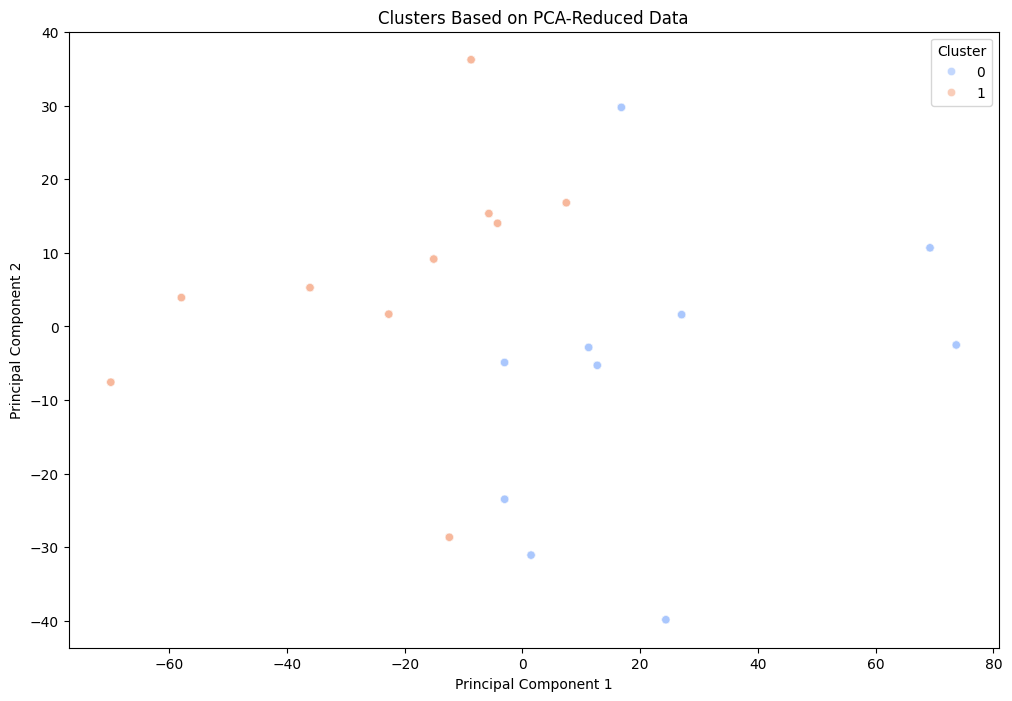

In [ ]:
# Visualize using the first two PCA components
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca_reduced[:, 0], y=X_pca_reduced[:, 1], hue=merged_all_df['Cluster'], palette='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Based on PCA-Reduced Data')
plt.show()


In [ ]:
# Function to calculate the mean of features for each stimulus
def aggregate_features(df, feature_col):
    return np.stack(df.groupby('Stimulus')[feature_col].apply(np.mean).values)

# Aggregate the features by Stimulus
stimulus_mfcc = aggregate_features(merged_all_df, 'mfcc_features')
stimulus_chroma = aggregate_features(merged_all_df, 'chroma_features')
stimulus_spectrogram = aggregate_features(merged_all_df, 'spectrogram_features')
stimulus_tempo = merged_all_df.groupby('Stimulus')['tempo'].mean().values

# Concatenate the aggregated features into a single feature matrix
X_stimulus = np.concatenate([stimulus_mfcc, stimulus_chroma, stimulus_spectrogram, stimulus_tempo.reshape(-1, 1)], axis=1)

print("Stimulus-level feature matrix shape:", X_stimulus.shape)


Stimulus-level feature matrix shape: (19, 3001)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the feature matrix
scaler = StandardScaler()
X_scaled_stimulus = scaler.fit_transform(X_stimulus)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=10)
X_pca_stimulus = pca.fit_transform(X_scaled_stimulus)

print("PCA-reduced feature matrix shape:", X_pca_stimulus.shape)


PCA-reduced feature matrix shape: (19, 10)


In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
stimulus_clusters = kmeans.fit_predict(X_pca_stimulus)

# Create a DataFrame with Stimulus and Cluster labels
stimulus_cluster_df = pd.DataFrame({
    'Stimulus': merged_all_df['Stimulus'].unique(),
    'Cluster': stimulus_clusters
})

# Display the first few rows
stimulus_cluster_df


                     Stimulus  Cluster
0         Miserere Me (Audio)        1
1  3rd Grade Drop Out (Audio)        1
2            Unbroken (Audio)        1
3      Laughing Heart (Audio)        0
4    Hallelujah Choir (Audio)        1


In [ ]:
stimulus_cluster_df

,Stimulus,Cluster
0,Miserere Me (Audio),1
1,3rd Grade Drop Out (Audio),1
2,Unbroken (Audio),1
3,Laughing Heart (Audio),0
4,Hallelujah Choir (Audio),1
5,Jason Silva (Audio),1
6,Clair de Lune (Audio),1
7,Pale Blue Dot (Audio),0
8,Motorcycle Diaries (Audio),1
9,Duo Des Fleurs (Audio),1


chills no for 0 chills yes for 1

In [ ]:
# Calculate the mean and standard deviation of each feature by cluster
feature_analysis = pd.DataFrame({
    'Cluster 0 Mean': X_stimulus[stimulus_clusters == 0].mean(axis=0),
    'Cluster 0 Std': X_stimulus[stimulus_clusters == 0].std(axis=0),
    'Cluster 1 Mean': X_stimulus[stimulus_clusters == 1].mean(axis=0),
    'Cluster 1 Std': X_stimulus[stimulus_clusters == 1].std(axis=0)
})

# Display the feature analysis
print(feature_analysis)


      Cluster 0 Mean  Cluster 0 Std  Cluster 1 Mean  Cluster 1 Std
0        -587.944580      18.740051     -548.228893      52.596490
1        -587.944580      18.740051     -548.228893      52.596490
2        -587.944580      18.740051     -548.228893      52.596490
3        -587.944580      18.740051     -548.228893      52.596490
4        -587.944580      18.740051     -548.228893      52.596490
...              ...            ...             ...            ...
2996      -62.389633       8.442062      -58.597467       7.664379
2997      -55.443834       4.052034      -56.544462       9.427952
2998      -54.966772       5.795645      -59.671543      10.359684
2999      -53.846766       5.741606      -59.562891      11.610355
3000        0.000000       0.000000        0.000000       0.000000

[3001 rows x 4 columns]


In [ ]:
# Define feature group indices
n_mfcc = 1000  # Adjust to match the number of MFCC features
n_chroma = 100  # Adjust to match the number of Chroma features
n_spectrogram = 1000  # Adjust to match the number of Spectrogram features

# Split features by group
mfcc_features = X_stimulus[:, :n_mfcc]
chroma_features = X_stimulus[:, n_mfcc:n_mfcc + n_chroma]
spectrogram_features = X_stimulus[:, n_mfcc + n_chroma:n_mfcc + n_chroma + n_spectrogram]
tempo_features = X_stimulus[:, -1]


In [ ]:
# Calculate mean and standard deviation for each feature group
group_summary = {
    'Feature Group': ['MFCC', 'Chroma', 'Spectrogram', 'Tempo'],
    'Cluster 0 Mean': [
        mfcc_features[stimulus_clusters == 0].mean(),
        chroma_features[stimulus_clusters == 0].mean(),
        spectrogram_features[stimulus_clusters == 0].mean(),
        tempo_features[stimulus_clusters == 0].mean()
    ],
    'Cluster 0 Std': [
        mfcc_features[stimulus_clusters == 0].std(),
        chroma_features[stimulus_clusters == 0].std(),
        spectrogram_features[stimulus_clusters == 0].std(),
        tempo_features[stimulus_clusters == 0].std()
    ],
    'Cluster 1 Mean': [
        mfcc_features[stimulus_clusters == 1].mean(),
        chroma_features[stimulus_clusters == 1].mean(),
        spectrogram_features[stimulus_clusters == 1].mean(),
        tempo_features[stimulus_clusters == 1].mean()
    ],
    'Cluster 1 Std': [
        mfcc_features[stimulus_clusters == 1].std(),
        chroma_features[stimulus_clusters == 1].std(),
        spectrogram_features[stimulus_clusters == 1].std(),
        tempo_features[stimulus_clusters == 1].std()
    ]
}

# Convert to a DataFrame for easier visualization
group_summary_df = pd.DataFrame(group_summary)
print(group_summary_df)


  Feature Group  Cluster 0 Mean  Cluster 0 Std  Cluster 1 Mean  Cluster 1 Std
0          MFCC     -566.452483      44.631981     -363.205692     110.408106
1        Chroma        0.000000       0.000000        0.339003       0.338557
2   Spectrogram       -7.890150      24.038218       -6.198840      20.397399
3         Tempo        0.000000       0.000000        0.000000       0.000000


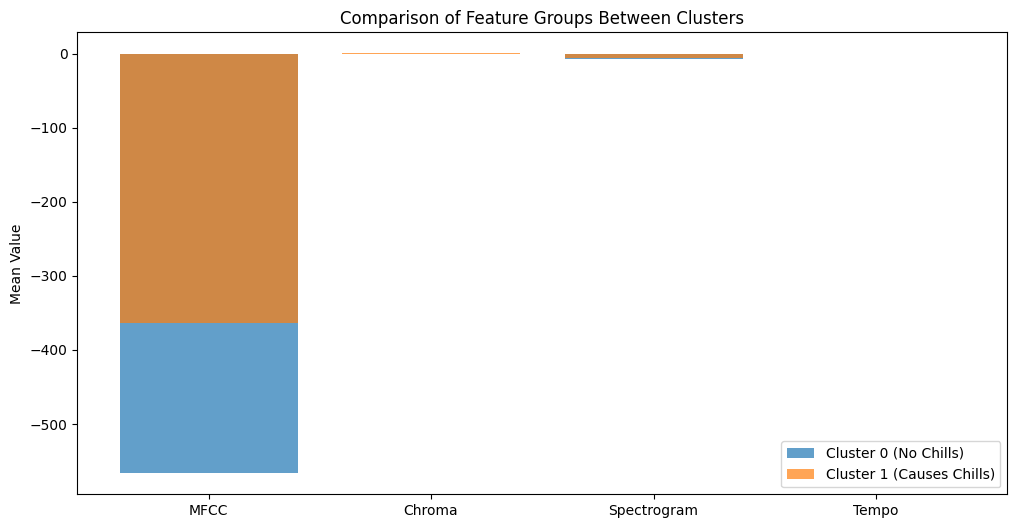

In [ ]:
# Plot mean feature differences
plt.figure(figsize=(12, 6))
x = group_summary_df['Feature Group']
plt.bar(x, group_summary_df['Cluster 0 Mean'], label='Cluster 0 (No Chills)', alpha=0.7)
plt.bar(x, group_summary_df['Cluster 1 Mean'], label='Cluster 1 (Causes Chills)', alpha=0.7)
plt.ylabel('Mean Value')
plt.title('Comparison of Feature Groups Between Clusters')
plt.legend()
plt.show()


the thing that may be causing chills is the mfcc in both the average one and full mfcc shows the greatest difference. the clustering seemed better when all features were kept but both had the saem reason for being different.

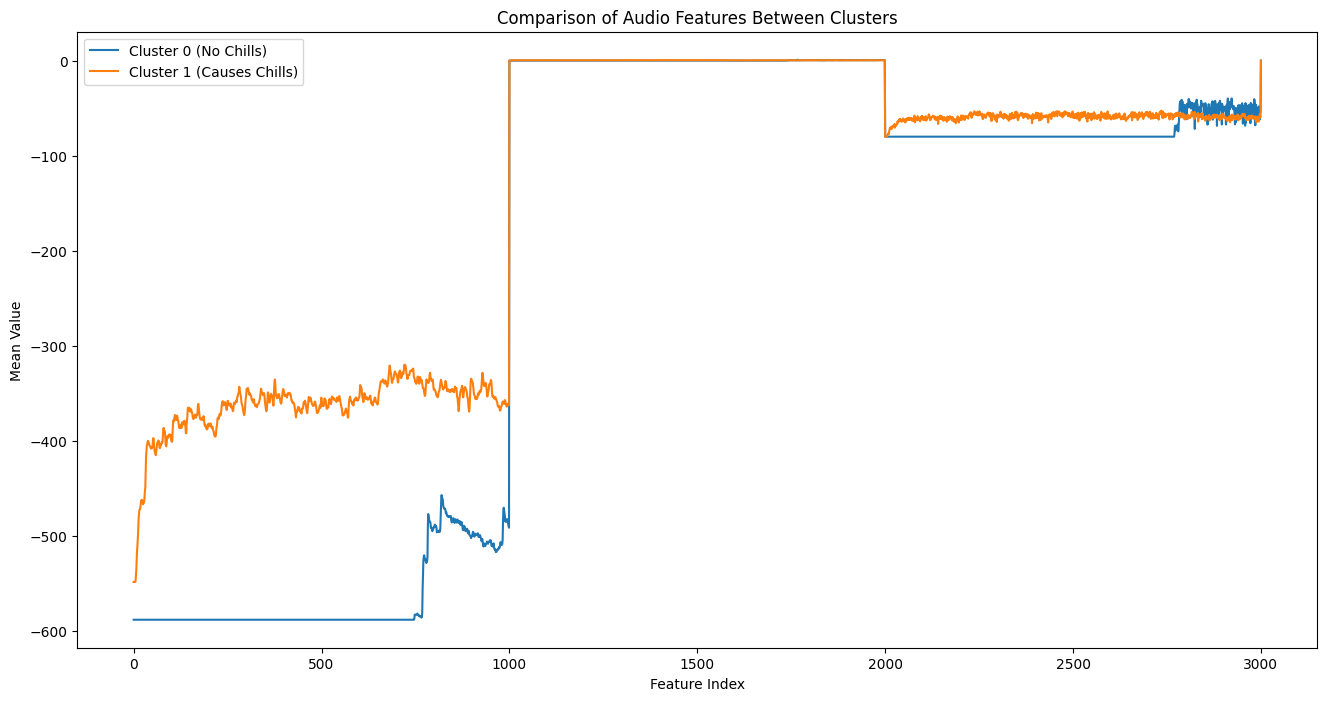

In [ ]:
import matplotlib.pyplot as plt

# Plot the mean values for each feature in both clusters
plt.figure(figsize=(16, 8))
plt.plot(feature_analysis.index, feature_analysis['Cluster 0 Mean'], label='Cluster 0 (No Chills)')
plt.plot(feature_analysis.index, feature_analysis['Cluster 1 Mean'], label='Cluster 1 (Causes Chills)')
plt.xlabel('Feature Index')
plt.ylabel('Mean Value')
plt.title('Comparison of Audio Features Between Clusters')
plt.legend()
plt.show()


In [ ]:
merged_all_df['Stimulus'].unique()

array(['Miserere Me (Audio)', '3rd Grade Drop Out (Audio)',
       'Unbroken (Audio)', 'Laughing Heart (Audio)',
       'Hallelujah Choir (Audio)', 'Jason Silva (Audio)',
       'Clair de Lune (Audio)', 'Pale Blue Dot (Audio)',
       'Motorcycle Diaries (Audio)', 'Duo Des Fleurs (Audio)',
       'Radiohead Reckoner (Audio)', 'Wild Geese (Audio)',
       'Great Dictator (Audio)', 'Think Too Much Feel Too Little (audio)',
       'Aramaic (Audio)', 'Dead Poets (Audio)', 'Feynman (audio)',
       'Sigur Ros - Hoppipolla (Audio)', 'Agnus Dei (Audio)'],
      dtype=object)

In [ ]:
# Check the shape of each feature for all rows
print("MFCC feature shapes:")
print(merged_all_df['mfcc_features'].apply(lambda x: np.array(x).shape).value_counts())

print("\nChroma feature shapes:")
print(merged_all_df['chroma_features'].apply(lambda x: np.array(x).shape).value_counts())

print("\nSpectrogram feature shapes:")
print(merged_all_df['spectrogram_features'].apply(lambda x: np.array(x).shape).value_counts())


MFCC feature shapes:
mfcc_features
(1000,)    1462
Name: count, dtype: int64

Chroma feature shapes:
chroma_features
(1000,)    1462
Name: count, dtype: int64

Spectrogram feature shapes:
spectrogram_features
(1000,)    1462
Name: count, dtype: int64


In [ ]:
merged_all_df['tempo']

,tempo
0,[53.57142857142857]
1,[53.57142857142857]
2,[53.57142857142857]
3,[53.57142857142857]
4,[53.57142857142857]
...,...
1457,[112.5]
1458,[112.5]
1459,[112.5]
1460,[112.5]


In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
merged_all_df['Cluster'] = kmeans.fit_predict(X_pca_reduced)

# Check cluster distribution
print("Cluster distribution:")
print(merged_all_df['Cluster'].value_counts())


ValueError: Length of values (20) does not match length of index (1462)

In [ ]:

# Create the full feature matrix by concatenating features from merged_all_df
X_full = np.array([
    np.concatenate([
        row['mfcc_features'].flatten(),
        row['chroma_features'].flatten(),
        row['spectrogram_features'].flatten(),
        [row['tempo']]  # Ensure tempo is wrapped in a list so it concatenates as a 1D array
    ])
    for _, row in merged_all_df.iterrows()
])

print("Full feature matrix shape:", X_full.shape)  # Should be (1462, total_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# incremental PCA to reduce dimensionality (20 components)
ipca = IncrementalPCA(n_components=20, batch_size=100)
X_pca_reduced = ipca.fit_transform(X_scaled)

print("Reduced feature matrix shape:", X_pca_reduced.shape)  # Should be (1462, 20)

# 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
merged_all_df['Cluster'] = kmeans.fit_predict(X_pca_reduced)

# Check the cluster distribution
print("Cluster distribution:")
print(merged_all_df['Cluster'].value_counts())

# Visualize clusters using the first two principal components
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca_reduced[:, 0], y=X_pca_reduced[:, 1], hue=merged_all_df['Cluster'], palette='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Based on PCA-Reduced Data')
plt.show()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 3 has 2 dimension(s)

In [ ]:
df_all_features.head()

,file,tempo,chroma_features,mfcc_features,spectrogram_features
0,/content/drive/MyDrive/music/music/Miserere Me...,[53.57142857142857],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-522.78143, -522.78143, -522.78143, -522.7814...","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80..."
1,/content/drive/MyDrive/music/music/3rd Grade D...,[98.6842105263158],"[0.0, 0.0, 0.0, 0.0, 0.5345075, 0.8932723, 0.9...","[-487.73962, -487.73962, -487.73962, -487.7396...","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -72..."
2,/content/drive/MyDrive/music/music/Unbroken (A...,[119.68085106382979],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.82254916, 0.530599...","[-528.97284, -528.97284, -528.97284, -528.9728...","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80..."
3,/content/drive/MyDrive/music/music/Laughing He...,[96.98275862068965],"[0.0, 0.42406973, 0.4101804, 0.4647976, 0.5655...","[-594.896, -594.896, -594.896, -594.896, -594....","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -65..."
4,/content/drive/MyDrive/music/music/Hallelujah ...,[181.4516129032258],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-538.9066, -538.9066, -538.9066, -538.9066, -...","[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80..."


In [ ]:
# Export the final DataFrame with clusters to a CSV file
df_all_features.to_csv("df_all_features.csv", index=False)

# If you're in a Jupyter/Colab environment and want to download the file:
from google.colab import files
files.download("df_all_features.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_features

,file,tempo,mean_chroma,mean_mfcc,spectrogram_mean
0,Air France [yEKe5xrAsyo].mp3,[80.35714285714286],0.325131,-12.095536,-72.645218
1,Be Kind [hyQpXYFhL2A].mp3,[127.8409090909091],0.473116,-11.961370,-71.585495
2,Mr. Rogers Testimony [iiFEiUe8k8U].mp3,[117.1875],0.524611,-21.945652,-73.368385
3,Hunger Games [LY2BbmeAP6M].mp3,[100.44642857142857],0.396639,-9.105456,-74.582359
4,Cloud Atlas [tnXHFqw1ckk].mp3,[140.625],0.442566,-18.861334,-73.186020
5,A Thing About Life [5MveHH5k10I].mp3,[127.8409090909091],0.456557,-4.816804,-70.243034
6,Remember the Titans [RbWWQbMqKdQ].mp3,[170.45454545454547],0.441364,-11.716263,-68.768394
7,Remember the Titans [RbWWQbMqKdQ].mp3,[170.45454545454547],0.441364,-11.716263,-68.768394
8,Amélie [7BLhxyMyNOc].mp3,[137.1951219512195],0.361533,-17.026983,-69.556419
9,Thai Medicine [mn26zmFwUNk].mp3,[53.57142857142857],0.402286,-23.350702,-76.420174


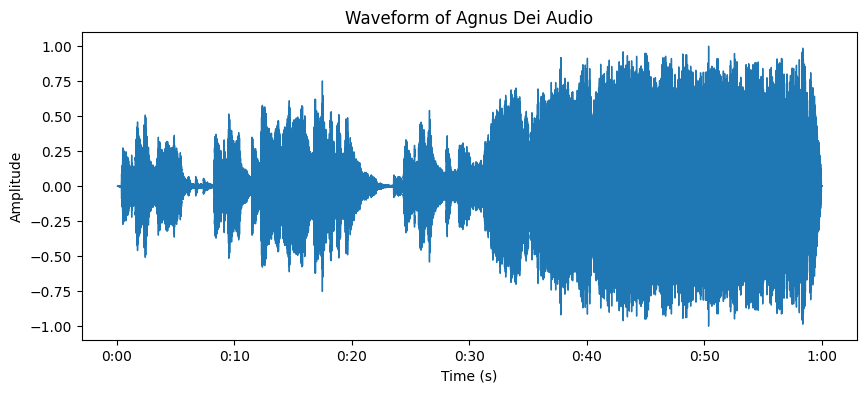

In [ ]:
# Load the audio file (replace the file path if it's different)
audio_path = 'Air France [yEKe5xrAsyo].mp3'

# Load the audio file with librosa (this will convert it to a waveform)
y, sr = librosa.load(audio_path, sr=None)  # sr=None to preserve the original sample rate

# Normalize the audio to have values between -1 and 1 (if needed)
y = librosa.util.normalize(y)

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Agnus Dei Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
